---

EQUIPE:

* Ana Carolina Aguiar - Mat.: 20210024326
* Cassiano Sabino - Mat.: 20210025806
* Geovana Lima - Mat.: 20210024729

---

## Load the Data


---

EQUIPE:

⇒ Primeiro, fizemos o download dos dados da DBPedia e carregamos em um dataframe Pandas. Removemos as colunas l2 e l3, pois estamos interessados apenas na coluna l1, para usar o rótulo de primeiro nível (que contém 9 classes).

---

In [1]:
!curl -L -o dbpedia-classes.zip https://www.kaggle.com/api/v1/datasets/download/danofer/dbpedia-classes

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  165M  100  165M    0     0  26.2M      0  0:00:06  0:00:06 --:--:-- 33.4M


In [2]:
!unzip dbpedia-classes.zip

Archive:  dbpedia-classes.zip
  inflating: DBPEDIA_test.csv        
  inflating: DBPEDIA_train.csv       
  inflating: DBPEDIA_val.csv         
  inflating: DBP_wiki_data.csv       


In [3]:
import pandas as pd

In [4]:
train_df = pd.read_csv("/content/DBPEDIA_train.csv")
test_df = pd.read_csv("/content/DBPEDIA_test.csv")

In [5]:
train_df.drop(columns=["l2", "l3"])
test_df.drop(columns=["l2", "l3"])

,text,l1
0,Liu Chao-shiuan (Chinese: 劉兆玄; pinyin: Liú Zhà...,Agent
1,"Michelle Maylene (born January 20, 1987) is an...",Agent
2,Hirfanlı Dam is a dam in Turkey. The developme...,Place
3,Grote Prijs Stad Zottegem is a single-day road...,Event
4,"Johannes Petrus \""Hans\"" Nijman (September 23,...",Agent
...,...,...
60789,Darwin Smith was CEO of Kimberly-Clark from 19...,Agent
60790,The HKRU Premiership is the main domestic comp...,Agent
60791,"Leo Harvey Diegel (April 20, 1899 – May 5, 195...",Agent
60792,"Clement Reginald \""Clem\"" Splatt (17 September...",Agent


---

EQUIPE:

⇒ Renomeamos as colunas para usarmos o padrão "text" e "label".

---

In [6]:
train_df = train_df.rename(columns={"text": "text", "l1": "label"})
test_df = test_df.rename(columns={"text": "text", "l1": "label"})

# Classic Markov

---

EQUIPE:

⇒ Pré-processamento dos textos: Nesta etapa, importamos bibliotecas necessárias e definimos a função `preprocess`, que normaliza o texto (converte para minúsculas), remove pontuações e caracteres especiais, e realiza a tokenização em palavras usando a biblioteca NLTK.

---

In [7]:
import re
from collections import defaultdict, Counter
import numpy as np
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return word_tokenize(text)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


---

EQUIPE:

⇒ Implementação do Modelo de Markov para modelagem de linguagem: esta classe constrói um modelo de primeira ordem baseado em cadeias de Markov.
- Durante o treinamento, ela coleta as transições entre palavras consecutivas nos textos (com tokens <START> e <END>).
- Em seguida, calcula as probabilidades condicionais de transição entre palavras.
- O método `sequence_log_prob` calcula a verossimilhança (log da probabilidade) de uma nova sequência de texto, considerando as transições observadas durante o treinamento e aplicando suavização de Laplace para lidar com palavras não vistas.


---

In [8]:
class MarkovModel:
    def __init__(self):
        self.transitions = defaultdict(Counter)
        self.vocab = set()

    def train(self, texts):
        for text in texts:
            tokens = preprocess(text)
            tokens = ["<START>"] + tokens + ["<END>"]
            self.vocab.update(tokens)
            for i in range(len(tokens) - 1):
                self.transitions[tokens[i]][tokens[i + 1]] += 1

        self.vocab = list(self.vocab)
        self._calculate_probabilities()

    def _calculate_probabilities(self):
        self.probabilities = {}
        for prev_word, next_words in self.transitions.items():
            total = sum(next_words.values())
            self.probabilities[prev_word] = {
                word: count / total for word, count in next_words.items()
            }

    def sequence_log_prob(self, text):
        tokens = preprocess(text)
        tokens = ["<START>"] + tokens + ["<END>"]
        log_prob = 0.0
        for i in range(len(tokens) - 1):
            prev_word = tokens[i]
            next_word = tokens[i + 1]
            prob = self.probabilities.get(prev_word, {}).get(next_word, 1e-6)  # Laplace smoothing
            log_prob += np.log(prob)
        return log_prob


---

EQUIPE:

⇒ Treinamento de um modelo de Markov por classe:
* Para cada rótulo de classe presente no dataset de treino, treinamos um modelo de Markov específico usando apenas os textos daquela classe.
* O resultado é um dicionário `models`, onde cada chave é um rótulo e o valor é o modelo treinado correspondente.

---

In [9]:
models = {}
classes = train_df['label'].unique()

for cls in classes:
    model = MarkovModel()
    model.train(train_df[train_df['label'] == cls]['text'])
    models[cls] = model


---

EQUIPE:

⇒ Função de classificação: dada uma entrada textual e os modelos de Markov treinados por classe, a função computa a probabilidade logarítmica do texto pertencer a cada classe e retorna a classe com maior probabilidade estimada.

---

In [10]:
def classify(text, models):
    class_probs = {}
    for cls, model in models.items():
        class_probs[cls] = model.sequence_log_prob(text)
    return max(class_probs, key=class_probs.get)


---

EQUIPE:

⇒ Avaliação do classificador de Markov:
- Utiliza a função `classify` para prever as classes de todos os exemplos do conjunto de teste.
- Em seguida, calcula a acurácia comparando as predições com os rótulos reais.

---

In [11]:
predictions = [classify(text, models) for text in test_df['text']]
accuracy = np.mean(np.array(predictions) == test_df['label'].values)
print(f"Acurácia (Markov Clássico): {accuracy:.4f}")

Acurácia (Markov Clássico): 0.9549


# Métricas de avaliação do modelo

<Figure size 1000x1000 with 0 Axes>

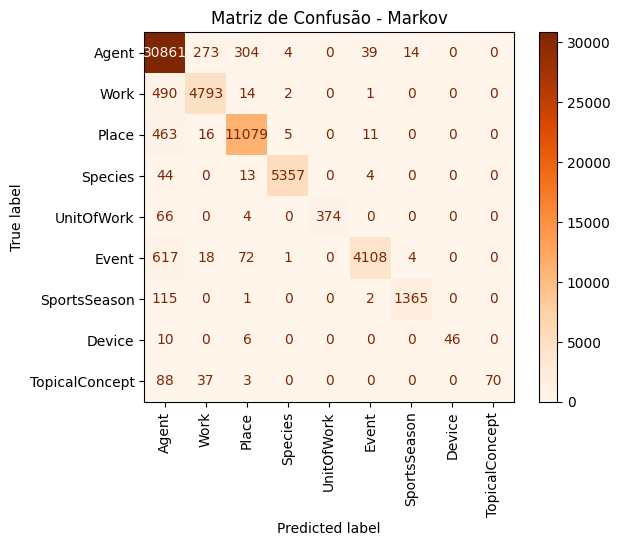

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

# gerar matriz de confusao
cm = confusion_matrix(test_df['label'], predictions, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# plotar
plt.figure(figsize=(10, 10))
disp.plot(xticks_rotation="vertical", cmap="Oranges", values_format='d')
plt.title("Matriz de Confusão - Markov")
plt.show()

In [15]:
from sklearn.metrics import classification_report

print(classification_report(test_df['label'], predictions, target_names=classes))

                precision    recall  f1-score   support

         Agent       0.94      0.98      0.96     31495
          Work       1.00      0.74      0.85        62
         Place       0.99      0.85      0.91      4820
       Species       0.96      0.96      0.96     11574
    UnitOfWork       1.00      0.99      0.99      5418
         Event       0.99      0.92      0.95      1483
  SportsSeason       1.00      0.35      0.52       198
        Device       1.00      0.84      0.91       444
TopicalConcept       0.93      0.90      0.92      5300

      accuracy                           0.95     60794
     macro avg       0.98      0.84      0.89     60794
  weighted avg       0.96      0.95      0.95     60794



---

EQUIPE:

⇒ O modelo baseado em Markov teve bom desempenho geral, com:
- Acurácia global de 95.5%
- F1-score médio ponderado de 95%

⇒ Destaques positivos:
- Classes como "Agent", "Species" e "UnitOfWork" tiveram F1-scores acima de 95%, mostrando que o modelo consegue capturar padrões frequentes de forma eficaz.
- No entanto, o modelo Markov teve desempenho consideravelmente inferior em:
  - "SportsSeason": F1-score de apenas 52% (recall de 35%)
  - "Work": recall de 74%, sugerindo dificuldade de identificação completa da classe
  - "Device": F1-score de 91% (recall de 84%)

⇒ Isso sugere que o modelo tem mais dificuldade em capturar nuances semânticas, especialmente em classes com pouca frequência ou que dependem de contexto mais profundo — limitações naturais de modelos estatísticos mais simples como Markov.

---

# Comparação de desempenho: BERT vs. Modelo de Markov

---

EQUIPE:

⇒ O classificador baseado em BERT com MLM apresentou um desempenho superior ao modelo de Markov, alcançando uma acurácia próxima de 99.7% contra aproximadamente 95.5% do modelo probabilístico clássico.

⇒ Essa diferença se deve principalmente à capacidade do BERT de capturar representações contextuais ricas e semânticas por meio de pré-treinamento em larga escala, além de utilizar embeddings de subpalavras, o que o torna robusto a variações linguísticas.

⇒ Já o modelo de Markov considera apenas a probabilidade de transições entre palavras consecutivas, o que limita sua capacidade de entender o significado geral do texto. Ele não possui mecanismos para lidar com ambiguidade, sinônimos ou relações de longo alcance entre palavras, o que impacta diretamente seu desempenho em tarefas de classificação de texto mais complexas.

---